# Digital Signal and Image Processing Project - Image Retrieval

#Imports and Dataset

In [38]:
from google.colab import drive
import zipfile
import shutil
import os
import numpy as np
import random as python_random
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score, classification_report

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset Import and Split

The dataset is imported, extracted and divided into train-val-test sets, with a proportion of 60-20-20.

The folder "dataset" is created which contains 3 sub folders for the 3 splits. The images are still divided by category.

Dictionaries are used to map label indices to their corresponding category names and vice versa.

In [2]:
# Transfer dataset, and extract files
shutil.copy('/content/drive/My Drive/MammalsDataset.zip', 'MammalsDataset.zip')
zipf = zipfile.ZipFile('MammalsDataset.zip')
zipf.extractall()
zipf.close()

os.remove('MammalsDataset.zip') # Delete the copied zip file

In [5]:
dataset_origin_path = "mammals"
dataset_path = "dataset"
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# Create destination directories
for split in ['train', 'val', 'test']:
    split_path = os.path.join(dataset_path, split)
    os.makedirs(split_path, exist_ok=True)

# Iterate through each category (sub-folder)
for category in os.listdir(dataset_origin_path):
    category_path = os.path.join(dataset_origin_path, category)

    images = os.listdir(category_path)
    python_random.shuffle(images)

    train_end = int(train_ratio * len(images))
    val_end = train_end + int(val_ratio * len(images))

    splits = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    # Move images to respective directories
    for split, split_images in splits.items():
        split_category_path = os.path.join(dataset_path, split, category)
        os.makedirs(split_category_path, exist_ok=True)

        for img in split_images:
            shutil.move(os.path.join(category_path, img), os.path.join(split_category_path, img))

    # Remove empty category folder
    os.rmdir(category_path)

# Remove the original dataset folder if empty
if not os.listdir(dataset_origin_path):
    os.rmdir(dataset_origin_path)

print("Dataset split completed successfully.")


Dataset split completed successfully.


Dictionaries are created in order to map label indices to their corresponding category names and vice versa, whenever this will be needed later in the project.

In [10]:
category_names = sorted([d for d in os.listdir(dataset_path + "/train") if os.path.isdir(os.path.join(dataset_path + "/train", d))])
category_to_index = {name: i for i, name in enumerate(category_names)}
index_to_category = {i: name for name, i in category_to_index.items()}

# Pre-Trained CNN Approach
This section explores the base approach of extracting the feature arrays from a pre-trained network (MobileNetV2), and using a kd-tree to retrieve similar images quickly.

## Functions

In [19]:
def extract_features(model, root_folder, category_to_index, preprocess_function, image_size=(224, 224)):
    """
    Extract features from images in a root folder organized into subfolders by labels.
    Returns the features, the labels, and the corresponding image paths.
    """
    features = []
    labels = []
    image_paths = []

    for category in sorted(os.listdir(root_folder)):
        category_path = os.path.join(root_folder, category)
        print("Processing folder", category_path)

        if os.path.isdir(category_path):
            if category not in category_to_index:
                print(f"Skipping folder '{category}' as it is not in the category mapping.")
                continue

            label = category_to_index[category]  # Convert category name to label index

            image_files = [fname for fname in os.listdir(category_path) if fname.lower().endswith(('jpg', 'jpeg', 'png'))]

            for fname in image_files:
                image_path = os.path.join(category_path, fname)

                image = load_img(image_path, target_size=image_size)
                image_array = img_to_array(image)
                image_array = preprocess_function(image_array)
                image_array = np.expand_dims(image_array, axis=0)

                feature = model.predict(image_array, verbose=0)

                features.append(feature.flatten())
                labels.append(label)
                image_paths.append(image_path)

    return np.array(features), np.array(labels), image_paths

In [20]:
def load_or_compute_features(model, features_path, labels_path, paths_path, images_folder, category_to_index, preprocess_function=preprocess_input):
    """
    This function loads the saved features, labels and image paths (if available),
    otherwise it computes, saves them and returns them.
    """
    # Check if the feature, label, and image path files exist
    if os.path.exists(features_path):
        # Load the files if they exist
        train_features = np.load(features_path)
        train_labels = np.load(labels_path)
        train_image_paths = list(np.load(paths_path, allow_pickle=True))
        print("Loaded existing files.")
    else:
        # Otherwise, compute them
        print("Files missing, computing features...")
        train_features, train_labels, train_image_paths = extract_features(model, images_folder, category_to_index, preprocess_function)

        # Create the folder if it doesn't exist already
        features_save_folder = os.path.dirname(features_path)
        if not os.path.exists(features_save_folder):
            os.makedirs(features_save_folder)

        # Save the computed features, labels, and image paths
        np.save(features_path, train_features)
        np.save(labels_path, train_labels)
        np.save(paths_path, train_image_paths)
        print("Computed and saved new features.")

    return train_features, train_labels, train_image_paths

## Feature Extraction

Extraction of the features for every image in the train, val and test set. The numpy arrays are saved to disk to avoid re-computing them in later executions.

In [3]:
# Load of MobileNetV2 without the top layer
mobilenet = MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
dataset_train_path = dataset_path + "/train"
train_features_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/train_features.npy"
train_labels_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/train_labels.npy"
train_image_names_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/train_image_names.npy"

train_features, train_labels, train_image_paths = load_or_compute_features(mobilenet, train_features_path, train_labels_path, train_image_names_path, dataset_train_path, category_to_index)

Files missing, computing features...
Processing folder dataset/train/african_elephant
Processing folder dataset/train/alpaca
Processing folder dataset/train/american_bison
Processing folder dataset/train/anteater
Processing folder dataset/train/arctic_fox
Processing folder dataset/train/armadillo
Processing folder dataset/train/baboon
Processing folder dataset/train/badger
Processing folder dataset/train/blue_whale
Processing folder dataset/train/brown_bear
Processing folder dataset/train/camel
Processing folder dataset/train/dolphin
Processing folder dataset/train/giraffe
Processing folder dataset/train/groundhog
Processing folder dataset/train/highland_cattle
Processing folder dataset/train/horse
Processing folder dataset/train/jackal
Processing folder dataset/train/kangaroo
Processing folder dataset/train/koala
Processing folder dataset/train/manatee
Processing folder dataset/train/mongoose
Processing folder dataset/train/mountain_goat
Processing folder dataset/train/opossum
Process

In [17]:
dataset_val_path = dataset_path + "/val"
val_features_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/val_features.npy"
val_labels_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/val_labels.npy"
val_image_names_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/val_image_names.npy"

val_features, val_labels, val_image_paths = load_or_compute_features(mobilenet, val_features_path, val_labels_path, val_image_names_path, dataset_val_path, category_to_index)

Files missing, computing features...
Processing folder dataset/val/african_elephant
Processing folder dataset/val/alpaca
Processing folder dataset/val/american_bison
Processing folder dataset/val/anteater
Processing folder dataset/val/arctic_fox
Processing folder dataset/val/armadillo
Processing folder dataset/val/baboon
Processing folder dataset/val/badger
Processing folder dataset/val/blue_whale
Processing folder dataset/val/brown_bear
Processing folder dataset/val/camel
Processing folder dataset/val/dolphin
Processing folder dataset/val/giraffe
Processing folder dataset/val/groundhog
Processing folder dataset/val/highland_cattle
Processing folder dataset/val/horse
Processing folder dataset/val/jackal
Processing folder dataset/val/kangaroo
Processing folder dataset/val/koala
Processing folder dataset/val/manatee
Processing folder dataset/val/mongoose
Processing folder dataset/val/mountain_goat
Processing folder dataset/val/opossum
Processing folder dataset/val/orangutan
Processing fo

In [21]:
dataset_test_path = dataset_path + "/test"
test_features_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/test_features.npy"
test_labels_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/test_labels.npy"
test_image_names_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/test_image_names.npy"

test_features, test_labels, test_image_paths = load_or_compute_features(mobilenet, test_features_path, test_labels_path, test_image_names_path, dataset_test_path, category_to_index)

Files missing, computing features...
Processing folder dataset/test/african_elephant
Processing folder dataset/test/alpaca
Processing folder dataset/test/american_bison
Processing folder dataset/test/anteater
Processing folder dataset/test/arctic_fox
Processing folder dataset/test/armadillo
Processing folder dataset/test/baboon
Processing folder dataset/test/badger
Processing folder dataset/test/blue_whale
Processing folder dataset/test/brown_bear
Processing folder dataset/test/camel
Processing folder dataset/test/dolphin
Processing folder dataset/test/giraffe
Processing folder dataset/test/groundhog
Processing folder dataset/test/highland_cattle
Processing folder dataset/test/horse
Processing folder dataset/test/jackal
Processing folder dataset/test/kangaroo
Processing folder dataset/test/koala
Processing folder dataset/test/manatee
Processing folder dataset/test/mongoose
Processing folder dataset/test/mountain_goat
Processing folder dataset/test/opossum
Processing folder dataset/test

This means that the train features are 1280 long arrays, for each of the 8234 images.

In [22]:
train_features.shape

(8234, 1280)

## Image Retrieval
This section creates the kd-tree, evaluates it and explores the results.

### Functions

In [ ]:
def print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, query_indexes, query_distances):
    """
    Plots the query image and its k nearest neighbors for each test image.
    """
    # Number of test images to plot
    num_test_images = len(test_image_indices)

    # Number of nearest neighbors to display
    k = len(query_indexes[0])

    # Adjust the figsize dynamically based on the number of images to display horizontally
    fig_width = 3 * (k + 1)  # 1 for the query image and k for neighbors
    fig_height = 3 * num_test_images  # 3 units of height per image row

    # Set up the plot with multiple rows (one for each test image) and (k + 1) columns (1 for the query image and k for neighbors)
    fig, axes = plt.subplots(num_test_images, k + 1, figsize=(fig_width, fig_height))

    # Loop over each test image index
    for i, test_image_index in enumerate(test_image_indices):
        # Get the test image
        test_image_path = test_image_paths[test_image_index]
        test_image = load_img(test_image_path)

        # Extract category (folder name) and image name for the test image
        test_image_category = os.path.basename(os.path.dirname(test_image_path))
        test_image_name = os.path.basename(test_image_path)

        # Plot the test image (query)
        axes[i, 0].imshow(test_image)
        axes[i, 0].set_title(f"Query:\n {test_image_name}")
        axes[i, 0].axis('off')  # Hide axes for the image

        # Plot the k nearest images
        for j, (index, dist) in enumerate(zip(query_indexes[i], query_distances[i])):
            # Load the neighbor image
            neighbor_image_path = train_image_paths[index]
            neighbor_image = load_img(neighbor_image_path)

            # Extract the category (folder name) and name for the neighbor image
            neighbor_category = os.path.basename(os.path.dirname(neighbor_image_path))
            neighbor_name = os.path.basename(neighbor_image_path)

            # Plot the neighbor image
            axes[i, j + 1].imshow(neighbor_image)
            axes[i, j + 1].set_title(f"{neighbor_name}\n(Dist: {dist:.2f})")
            axes[i, j + 1].axis('off')  # Hide axes for the image

    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_performance(query_indexes, test_labels, train_labels, index_to_category, k=3):
    """
    Evaluate the performance of the using the provided indices.
    For each test image, check each of the k nearest neighbors individually.
    """
    # List to store predictions and true labels for classification report
    predicted_labels = []
    true_labels = []

    # Loop over each test image
    for i, query_index in enumerate(query_indexes):
        # Get the true label for the test image
        true_label = test_labels[i]

        # Get the labels of the k nearest neighbors
        neighbor_labels = train_labels[query_index]

        # Check each neighbor individually and append to predictions
        for neighbor_label in neighbor_labels:
            predicted_labels.append(neighbor_label)  # Store the predicted neighbor label
            true_labels.append(true_label)           # Store the true label for the test sample

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Generate the classification report
    print("\nClassification Report:")

    # Convert numeric labels to category names using index_to_category
    category_names = [index_to_category[label] for label in np.unique(train_labels)]

    # Print the classification report with category names
    print(classification_report(true_labels, predicted_labels, target_names=category_names))

    # Generate classification report as a dictionary for easier extraction of metrics
    report = classification_report(true_labels, predicted_labels, target_names=category_names, output_dict=True)

    # Extract precision, recall, and f1-score for each class
    class_report = []
    for class_name, metrics in report.items():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore overall averages
            class_report.append({
                'Class': class_name,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score']
            })

    # Convert the class report to a DataFrame
    report_df = pd.DataFrame(class_report)

    return report_df


In [ ]:
def calculate_anmrr(query_indexes, test_labels, train_labels, k=3):
    """
    Calculate Average Normalized Modified Retrieval Rank (ANMRR)s.
    """
    tests_number = len(query_indexes)  # Number of queries
    total_score = 0

    for i, query_index in enumerate(query_indexes):
        true_label = test_labels[i]  # True label of the current query

        # Get the labels of the k nearest neighbors
        neighbor_labels = train_labels[query_index]

        # Compute AVR(q) - the average rank of relevant documents
        relevant_ranks = []
        for rank, neighbor_label in enumerate(neighbor_labels):
            if neighbor_label == true_label:
                relevant_ranks.append(rank + 1)  # Add 1 to convert from 0-indexed to 1-indexed rank

        if relevant_ranks:
            average_rank_relevant_documents = np.mean(relevant_ranks)  # Average rank of relevant documents
        else:
            average_rank_relevant_documents = k + 1  # If no relevant documents found, set to K + 1

        # Calculate the ANMRR for the query
        number_relevant_documents = 1
        denominator = 1.25 * k - 0.5 * (1 + number_relevant_documents)
        if denominator == 0:  # Handle case when the denominator becomes zero
            continue  # Skip this query, as division by zero is not valid

        score = (average_rank_relevant_documents - 0.5 * (1 + number_relevant_documents)) / denominator
        total_score += score

    # Return the final ANMRR score
    ANMRR = total_score / tests_number
    return ANMRR

In [ ]:
def retrieve_and_evaluate_category(kd_tree, category_name, num_images, root_test_folder, category_to_index):
    """
    Retrieves and evaluates images for a specific category using a KD-Tree.
    """

    print(f"Retrieving images for category {category_name}...")

    # Get the category index from the category name using the category_to_index mapping
    if category_name not in category_to_index:
        raise ValueError(f"Category '{category_name}' not found in the category_to_index mapping.")

    category_index = category_to_index[category_name]

    # Find indices of test images belonging to the specified category
    test_image_indices = [i for i, label in enumerate(test_labels) if label == category_index]

    # Limit the number of images to num_images (if available)
    test_image_indices = test_image_indices[:min(num_images, len(test_image_indices))]

    # Extract features for the selected test images
    test_images = test_features[test_image_indices]

    # Perform k-NN search using the KD-Tree
    k = 3  # Number of neighbors to retrieve
    query_distances, query_indexes = kd_tree.query(test_images, k=k)

    # Print retrieved images
    print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, query_indexes, query_distances)

    # Calculate and print ANMRR
    anmrr_value = calculate_anmrr(query_indexes, test_labels[test_image_indices], train_labels, k=k)
    print(f"ANMRR for category {category_name}: {anmrr_value:.4f}")

### KD-Tree

The kd-tree is created on the train fetures that were extracted earlier.

In [24]:
kd_tree = KDTree(train_features)

#### Testing on a few images

Testing the kd-tree and its returned data on 3 random images.

In [63]:
len(test_features)

2786

The images are picked with 3 random indices, and their respective feature arrays are retrieved.

In [84]:
test_image_indices = [0, 1000, 2000]
test_images = test_features[test_image_indices]
test_images.shape

(3, 1280)

5 images are retrieved for each one of the 3 test images.

In [129]:
distances, indices = kd_tree.query(test_images, k=5)

In [120]:
distances

array([[11.66054006, 12.2628642 , 12.34946761, 12.62637917, 12.92708526],
       [24.20629408, 24.51491907, 24.56012745, 24.74629475, 24.77928495],
       [10.88933873, 11.49297876, 12.10918684, 12.15804577, 12.23076107]])

In [121]:
indices

array([[  78,  139,   52,   11,   56],
       [ 753, 4415, 4296, 4389, 8022],
       [5888, 6030, 5996, 5860, 5919]])

This function takes the result of the kd-tree query and displays dynamically the original image and all of the retrieved images, with useful informations displayed in the titles.

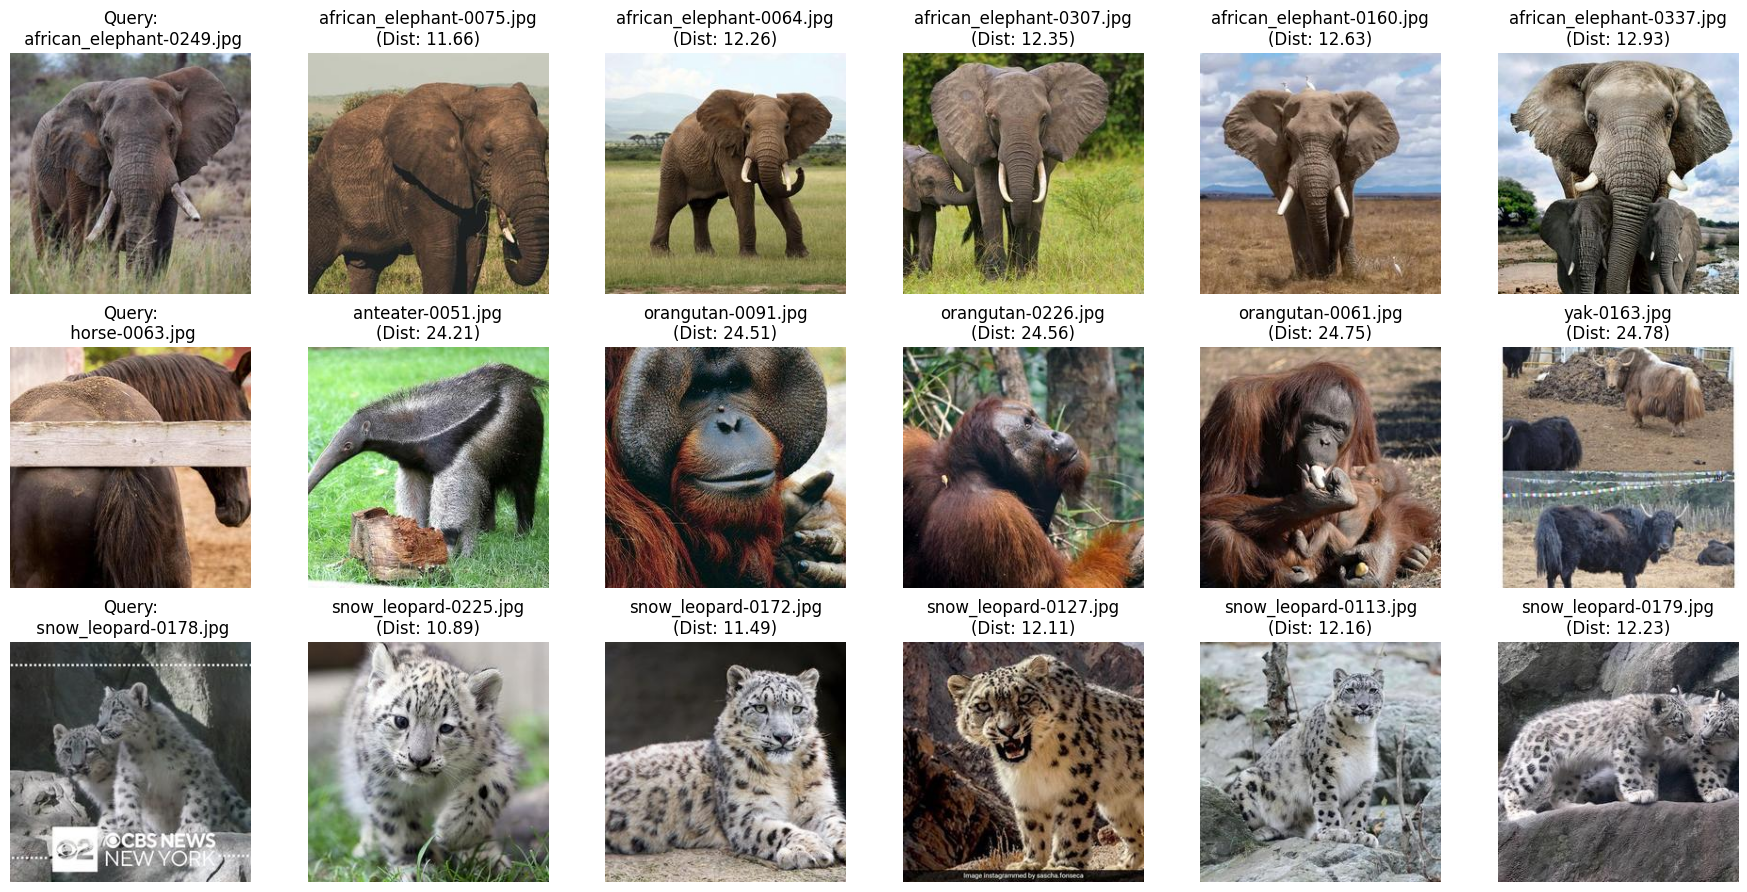

In [130]:
print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, indices, distances)

#### Evaluation
The method is then more thoroughly evaluated by retrieving 3 images for each test image.

In [150]:
k = 3
query_distances, query_indexes = kd_tree.query(test_features, k=k)

This function takes the result of the kd-tree query, calculates and displays the accuracy and the classification report.

In [186]:
performance_df = evaluate_performance(query_indexes, test_labels, train_labels, index_to_category, k)

Accuracy: 86.60%

Classification Report:
                  precision    recall  f1-score   support

african_elephant       0.95      0.96      0.96       210
          alpaca       0.85      0.84      0.85       204
  american_bison       0.79      0.93      0.85       210
        anteater       0.74      0.78      0.76       183
      arctic_fox       0.92      0.93      0.93       189
       armadillo       0.96      0.94      0.95       201
          baboon       0.95      0.94      0.95       198
          badger       0.90      0.81      0.85       186
      blue_whale       0.75      0.77      0.76       150
      brown_bear       0.91      0.98      0.94       180
           camel       0.86      0.88      0.87       156
         dolphin       0.79      0.86      0.82       189
         giraffe       0.93      0.92      0.93       183
       groundhog       0.83      0.94      0.88       189
 highland_cattle       0.81      0.92      0.86       189
           horse       0.91   

Since the classification report isn't much readable due to the large number of classes, the function also returns a dataframe which can be easily navigated.

In [233]:
performance_df.sort_values(by='F1-Score', ascending=False)[:10]

Class  Precision    Recall  F1-Score
23         orangutan   0.980583  0.990196  0.985366
31      snow_leopard   0.941704  1.000000  0.969977
27         red_panda   0.979695  0.960199  0.969849
44             zebra   0.963636  0.963636  0.963636
0   african_elephant   0.948357  0.961905  0.955083
26         porcupine   0.944444  0.958974  0.951654
5          armadillo   0.959391  0.940299  0.949749
6             baboon   0.949239  0.944444  0.946835
9         brown_bear   0.907692  0.983333  0.944000
18             koala   0.913462  0.974359  0.942928

Analyzing the classes which are harded to retrieve correctly will give us insights on what this method is struggling with.

In [232]:
performance_df.sort_values(by='F1-Score', ascending=True)[:10]

Class  Precision    Recall  F1-Score
43            yak   0.704348  0.519231  0.597786
30           seal   0.676829  0.560606  0.613260
29       sea_lion   0.709877  0.563725  0.628415
37         walrus   0.762500  0.701149  0.730539
3        anteater   0.737113  0.781421  0.758621
8      blue_whale   0.753247  0.773333  0.763158
35    vampire_bat   0.870690  0.687075  0.768061
39  water_buffalo   0.800000  0.770833  0.785146
36         vicuna   0.792308  0.798450  0.795367
11        dolphin   0.790244  0.857143  0.822335

The ANMRR (Average Normalized Modified Retrieval Rank) score is a measure of retrieval effectiveness. It ranges between 0 and 1 where 0 indicates perfect retrieval, meaning that all relevant items are ranked at the top, and 1 indicates worst-case retrieval, meaning relevant items are ranked very poorly or not retrieved at all. The "rank" is the position of the correctly retrieved images in the returned array, where the top of the ranking is occupied by the image with lowest distance to the query image.

A ANMRR score of 0.3914 is not bad.

In [220]:
anmrr_value = calculate_anmrr(query_indexes, test_labels, train_labels, k=3)
print(f"ANMRR: {anmrr_value:.4f}")

ANMRR: 0.3914


This function is used to explore a single category by testing on a given number of images, displaying the results and calculating the class-specific ANMRR score.

The issue with this class is clearly due to the high similarity with other categories like "highland_cattle" and "american_bison".

Some of these images could also be mistakes of the dataset itself, but since we are not experts of wild life, it's hard to tell.

Retrieving images for category yak...


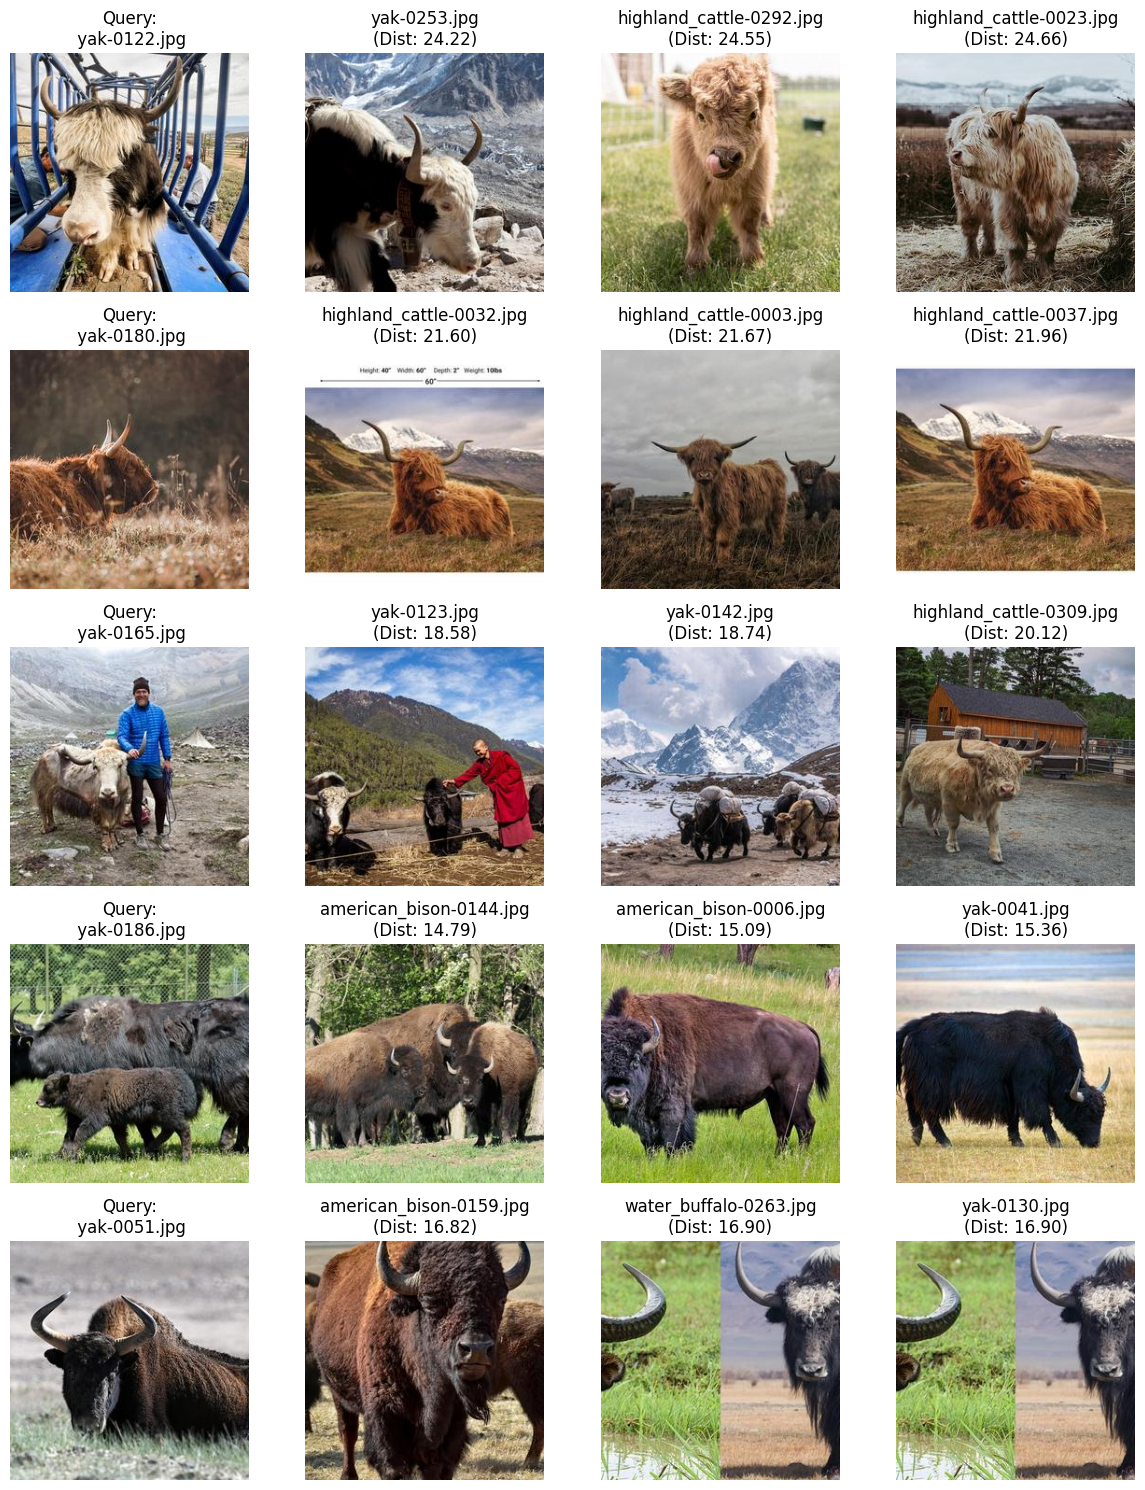

ANMRR for category yak: 0.5455


In [231]:
retrieve_and_evaluate_category(kd_tree, "yak", 5, dataset_test_path, category_to_index)